## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [505]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder


In [506]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [507]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [508]:
import pandas as pd

# 데이터 로드
train = pd.read_csv('../data/train.csv').drop(columns=['ID'])
test = pd.read_csv('../data/test.csv').drop(columns=['ID'])

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형', '특정_시술_유형',
       '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부', '난자

In [509]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_시기_코드               256351 non-null  object 
 1   시술_당시_나이               256351 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 3   시술_유형                  256351 non-null  object 
 4   특정_시술_유형               256349 non-null  object 
 5   배란_자극_여부               256351 non-null  int64  
 6   배란_유도_유형               256351 non-null  object 
 7   단일_배아_이식_여부            250060 non-null  float64
 8   착상_전_유전_검사_사용_여부       2718 non-null    float64
 9   착상_전_유전_진단_사용_여부       250060 non-null  float64
 10  남성_주_불임_원인             256351 non-null  int64  
 11  남성_부_불임_원인             256351 non-null  int64  
 12  여성_주_불임_원인             256351 non-null  int64  
 13  여성_부_불임_원인             256351 non-null  int64  
 14  부부_주_불임_원인             256351 non-nu

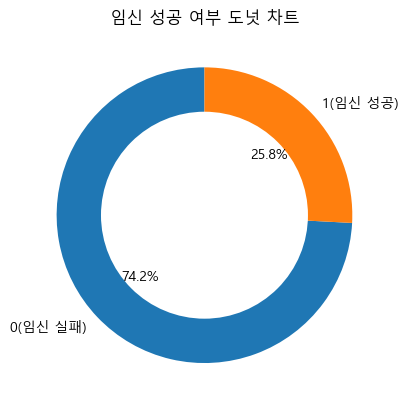

In [510]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [511]:
# '시술_유형' 변수의 값이 'DI'에 해당 안하는 데이터 추출
DI_train = train[train['시술_유형'] == 'DI'] # 
DI_test = test[test['시술_유형'] == 'DI']

# 새로운 데이터셋 생성
print("시술유형 DI 데이터셋:")
print(DI_train)

시술유형 DI 데이터셋:
       시술_시기_코드 시술_당시_나이  임신_시도_또는_마지막_임신_경과_연수 시술_유형 특정_시술_유형  배란_자극_여부  \
14       TRXQMD  만38-39세                    NaN    DI      IUI         0   
39       TRDQAZ  만18-34세                    NaN    DI      IUI         1   
127      TRJXFG  만35-37세                    NaN    DI      IUI         1   
162      TRXQMD  만38-39세                    NaN    DI      IUI         1   
174      TRCMWS  만40-42세                    NaN    DI      IUI         0   
...         ...      ...                    ...   ...      ...       ...   
256174   TRZKPL  만45-50세                    NaN    DI      IUI         1   
256222   TRYBLT  만18-34세                    NaN    DI      IUI         1   
256228   TRYBLT  만40-42세                    NaN    DI      IUI         1   
256301   TRCMWS  만40-42세                    NaN    DI      IUI         0   
256326   TRDQAZ  만40-42세                    NaN    DI      IUI         1   

       배란_유도_유형  단일_배아_이식_여부  착상_전_유전_검사_사용_여부  착상_전_유전_진단_사용_여부  ...  \


In [512]:
DI_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6291 entries, 14 to 256326
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   시술_시기_코드               6291 non-null   object 
 1   시술_당시_나이               6291 non-null   object 
 2   임신_시도_또는_마지막_임신_경과_연수  303 non-null    float64
 3   시술_유형                  6291 non-null   object 
 4   특정_시술_유형               6291 non-null   object 
 5   배란_자극_여부               6291 non-null   int64  
 6   배란_유도_유형               6291 non-null   object 
 7   단일_배아_이식_여부            0 non-null      float64
 8   착상_전_유전_검사_사용_여부       0 non-null      float64
 9   착상_전_유전_진단_사용_여부       0 non-null      float64
 10  남성_주_불임_원인             6291 non-null   int64  
 11  남성_부_불임_원인             6291 non-null   int64  
 12  여성_주_불임_원인             6291 non-null   int64  
 13  여성_부_불임_원인             6291 non-null   int64  
 14  부부_주_불임_원인             6291 non-null   int64  
 15  부

In [513]:
# 모든 값이 결측값인 변수를 제거
DI_train = DI_train.dropna(axis=1, how='all')
DI_test = DI_test.dropna(axis=1, how='all')

In [514]:
train = DI_train
test = DI_test

In [515]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6291 entries, 14 to 256326
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   시술_시기_코드               6291 non-null   object 
 1   시술_당시_나이               6291 non-null   object 
 2   임신_시도_또는_마지막_임신_경과_연수  303 non-null    float64
 3   시술_유형                  6291 non-null   object 
 4   특정_시술_유형               6291 non-null   object 
 5   배란_자극_여부               6291 non-null   int64  
 6   배란_유도_유형               6291 non-null   object 
 7   남성_주_불임_원인             6291 non-null   int64  
 8   남성_부_불임_원인             6291 non-null   int64  
 9   여성_주_불임_원인             6291 non-null   int64  
 10  여성_부_불임_원인             6291 non-null   int64  
 11  부부_주_불임_원인             6291 non-null   int64  
 12  부부_부_불임_원인             6291 non-null   int64  
 13  불명확_불임_원인              6291 non-null   int64  
 14  불임_원인_-_난관_질환          6291 non-null   int64  
 15  불

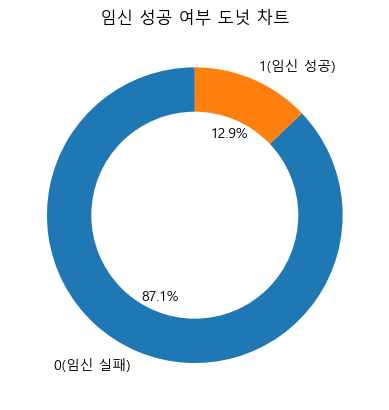

In [516]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [517]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1    0    1  Total
variable                                     
TRCMWS    0.862981  0.137019  718  114    832
TRDQAZ    0.887967  0.112033  856  108    964
TRJXFG    0.886770  0.113230  744   95    839
TRVNRY    0.877426  0.122574  859  120    979
TRXQMD    0.837808  0.162192  749  145    894
TRYBLT    0.865811  0.134189  742  115    857
TRZKPL    0.876890  0.123110  812  114    926


## 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [518]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
만18-34세   0.805408  0.194592  1668  403   2071
만35-37세   0.848966  0.151034  1231  219   1450
만38-39세   0.897436  0.102564   945  108   1053
만40-42세   0.930502  0.069498   964   72   1036
만43-44세   0.980907  0.019093   411    8    419
만45-50세   0.996183  0.003817   261    1    262


## 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [519]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       1.000000  0.000000   2.0  0.0      2
3.0       0.666667  0.333333   6.0  3.0      9
4.0       0.700000  0.300000   7.0  3.0     10
5.0       0.785714  0.214286  11.0  3.0     14
6.0       0.852941  0.147059  29.0  5.0     34
7.0       0.727273  0.272727  24.0  9.0     33
8.0       0.853659  0.146341  35.0  6.0     41
9.0       0.965517  0.034483  28.0  1.0     29
10.0      0.774194  0.225806  24.0  7.0     31
11.0      0.862069  0.137931  25.0  4.0     29
12.0      0.863636  0.136364  19.0  3.0     22
13.0      0.888889  0.111111  16.0  2.0     18
14.0      0.800000  0.200000   8.0  2.0     10
15.0      0.800000  0.200000   4.0  1.0      5
16.0      1.000000  0.000000   1.0  0.0      1
17.0      0.833333  0.166667   5.0  1.0      6
18.0      1.000000  0.000000   2.0  0.0      2
19.0      0.666667  0.333333   2.0  1.0      3
20.0      1.000000

In [520]:
# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

# 결측값을 known으로 채우기
train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

결측값 개수: 5988
결측값 개수: 0


In [521]:
test['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum()

0

In [522]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
1.0       1.000000  0.000000     2.0    0.0      2
3.0       0.666667  0.333333     6.0    3.0      9
4.0       0.700000  0.300000     7.0    3.0     10
5.0       0.785714  0.214286    11.0    3.0     14
6.0       0.852941  0.147059    29.0    5.0     34
7.0       0.727273  0.272727    24.0    9.0     33
8.0       0.853659  0.146341    35.0    6.0     41
9.0       0.965517  0.034483    28.0    1.0     29
10.0      0.774194  0.225806    24.0    7.0     31
11.0      0.862069  0.137931    25.0    4.0     29
12.0      0.863636  0.136364    19.0    3.0     22
13.0      0.888889  0.111111    16.0    2.0     18
14.0      0.800000  0.200000     8.0    2.0     10
15.0      0.800000  0.200000     4.0    1.0      5
16.0      1.000000  0.000000     1.0    0.0      1
17.0      0.833333  0.166667     5.0    1.0      6
18.0      1.000000  0.000000     2.0    

## 4. 시술_유형

IVF 또는 DI 시술 여부

In [523]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
DI        0.871086  0.128914  5480  811   6291


In [524]:
test['시술_유형'].value_counts()

DI    2176
Name: 시술_유형, dtype: int64

IVF 와 DI 시술중 DI 시술 데이터만 제공됨

In [525]:
# '시술_유형' 변수 제거
train = train.drop(columns=['시술_유형'])
test = test.drop(columns=['시술_유형'])

In [414]:
len(train['임신_성공_여부'])

6291

## 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [526]:
len(train['특정_시술_유형'])

6291

시술유형에 대해서 특정 시술 유형값이 존재하는거!

In [527]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

        group  '임신_성공_여부' count     ratio  Total
0        GIFT                 0  0.000000      1
1  Generic DI                12  0.169014     71
2         ICI                13  0.135417     96
3         IUI               784  0.128525   6100
4         IVI                 2  0.086957     23


In [528]:
test['특정_시술_유형'].value_counts()

IUI           2112
ICI             28
Generic DI      26
IVI              8
IUI:ICI          2
Name: 특정_시술_유형, dtype: int64

In [529]:
# '특정_시술_유형' 변수의 값이 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['GIFT'])]
test = test.loc[~test['특정_시술_유형'].isin(['GIFT'])]

In [530]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if ":" in treatment:
            return treatment.split(":")[0]  # ':' 앞의 단어로 이름을 바꿈
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [531]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                   0         1     0    1  Total
variable                                        
Generic DI  0.830986  0.169014    59   12     71
ICI         0.864583  0.135417    83   13     96
IUI         0.871475  0.128525  5316  784   6100
IVI         0.913043  0.086957    21    2     23


In [532]:
test['변환된_특정_시술_유형'].value_counts()

IUI           2114
ICI             28
Generic DI      26
IVI              8
Name: 변환된_특정_시술_유형, dtype: int64

In [533]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

## 10. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [534]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.874250  0.125750  5249  755   6004
1         0.804196  0.195804   230   56    286


## 11. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [535]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871067  0.128933  5371  795   6166
1         0.870968  0.129032   108   16    124


## 12. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [536]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.873895  0.126105  5142  742   5884
1         0.830049  0.169951   337   69    406


## 13. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [537]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871429  0.128571  5368  792   6160
1         0.853846  0.146154   111   19    130


## 14. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [538]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.874894  0.125106  5182  741   5923
1         0.809264  0.190736   297   70    367


## 15. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [539]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871144  0.128856  5422  802   6224
1         0.863636  0.136364    57    9     66


## 16. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [540]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.868226  0.131774  5047  766   5813
1         0.905660  0.094340   432   45    477


## 17. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [541]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.870433  0.129567  5408  805   6213
1         0.922078  0.077922    71    6     77


## 18. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [542]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.895925  0.104075  3056  355   3411
1         0.841612  0.158388  2423  456   2879


## 19. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [543]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871192  0.128808  5147  761   5908
1         0.869110  0.130890   332   50    382


## 22. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [544]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.869757  0.130243  5329  798   6127
1         0.920245  0.079755   150   13    163


## 23. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [545]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871541  0.128459  5448  803   6251
1         0.794872  0.205128    31    8     39


## 26. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [546]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0         0.871024  0.128976  5477.0  811.0   6288
1         1.000000  0.000000     2.0    0.0      2


## 28. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [547]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.926768  0.073232   367   29    396
1회        0.865406  0.134594   778  121    899
2회        0.866184  0.133816   958  148   1106
3회        0.876923  0.123077   912  128   1040
4회        0.853685  0.146315   776  133    909
5회        0.870095  0.129905   643   96    739
6회 이상     0.870108  0.129892  1045  156   1201


In [548]:
test['총_시술_횟수'].value_counts()

6회 이상    421
3회       375
1회       351
2회       346
4회       285
5회       265
0회       133
Name: 총_시술_횟수, dtype: int64

## 29. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [549]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.894336  0.105664   821   97    918
1회        0.870229  0.129771  1026  153   1179
2회        0.872414  0.127586  1012  148   1160
3회        0.875135  0.124865   813  116    929
4회        0.867758  0.132242   689  105    794
5회        0.865079  0.134921   545   85    630
6회 이상     0.842647  0.157353   573  107    680


## 30. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [550]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.861111  0.138889  3224  520   3744
1회        0.871795  0.128205   816  120    936
2회        0.898990  0.101010   534   60    594
3회        0.878282  0.121718   368   51    419
4회        0.892720  0.107280   233   28    261
5회        0.921212  0.078788   152   13    165
6회 이상     0.888889  0.111111   152   19    171


## 31. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [551]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.900973  0.099027  1019  112   1131
1회        0.873262  0.126738  1068  155   1223
2회        0.860793  0.139207   977  158   1135
3회        0.871397  0.128603   786  116    902
4회        0.857542  0.142458   614  102    716
5회        0.890435  0.109565   512   63    575
6회 이상     0.827303  0.172697   503  105    608


## 32. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [552]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0회        0.902511  0.097489  3379.0  365.0   3744
1회        0.830102  0.169898  1798.0  368.0   2166
2회        0.785933  0.214067   257.0   70.0    327
3회        0.847826  0.152174    39.0    7.0     46
4회        1.000000  0.000000     6.0    0.0      6
5회        0.000000  1.000000     0.0    1.0      1


## 33. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [553]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0회        0.869543  0.130457  5099.0  765.0   5864
1회        0.888041  0.111959   349.0   44.0    393
2회        0.935484  0.064516    29.0    2.0     31
3회        1.000000  0.000000     2.0    0.0      2


## 34. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [554]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0회        0.900752  0.099248  3712.0  409.0   4121
1회        0.823656  0.176344  1532.0  328.0   1860
2회        0.752809  0.247191   201.0   66.0    267
3회        0.810811  0.189189    30.0    7.0     37
4회        1.000000  0.000000     4.0    0.0      4
5회        0.000000  1.000000     0.0    1.0      1


## 35. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [555]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.899191  0.100809  3889  436   4325
1회        0.809258  0.190742  1451  342   1793
2회        0.801325  0.198675   121   30    151
3회        0.857143  0.142857    18    3     21


## 36. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [556]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.870367  0.129633  5237  780   6017
1회        0.890566  0.109434   236   29    265
2회        0.750000  0.250000     6    2      8


## 37. DI_출산_횟수

DI 시술로 출산한 횟수

In [557]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.898298  0.101702  4116  466   4582
1회        0.797558  0.202442  1241  315   1556
2회        0.800000  0.200000   108   27    135
3회        0.823529  0.176471    14    3     17


## 55. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [558]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
만20세 이하   0.859935  0.140065   264   43    307
만21-25세   0.867880  0.132120  1097  167   1264
만26-30세   0.873407  0.126593  1028  149   1177
만31-35세   0.867320  0.132680   974  149   1123
만36-40세   0.883860  0.116140  1035  136   1171
만41-45세   0.864238  0.135762   783  123    906
알 수 없음    0.871345  0.128655   298   44    342


## 67. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [559]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1       0      1  Total
variable                                
0         1.0  0.0  5479.0    0.0   5479
1         0.0  1.0     0.0  811.0    811


In [560]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6290 entries, 14 to 256326
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   시술_시기_코드               6290 non-null   object
 1   시술_당시_나이               6290 non-null   object
 2   임신_시도_또는_마지막_임신_경과_연수  6290 non-null   object
 3   배란_자극_여부               6290 non-null   int64 
 4   배란_유도_유형               6290 non-null   object
 5   남성_주_불임_원인             6290 non-null   int64 
 6   남성_부_불임_원인             6290 non-null   int64 
 7   여성_주_불임_원인             6290 non-null   int64 
 8   여성_부_불임_원인             6290 non-null   int64 
 9   부부_주_불임_원인             6290 non-null   int64 
 10  부부_부_불임_원인             6290 non-null   int64 
 11  불명확_불임_원인              6290 non-null   int64 
 12  불임_원인_-_난관_질환          6290 non-null   int64 
 13  불임_원인_-_남성_요인          6290 non-null   int64 
 14  불임_원인_-_배란_장애          6290 non-null   int64 
 15  불임_원인_-_여성_요인     

In [561]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2176 entries, 26 to 90046
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   시술_시기_코드               2176 non-null   object
 1   시술_당시_나이               2176 non-null   object
 2   임신_시도_또는_마지막_임신_경과_연수  2176 non-null   object
 3   배란_자극_여부               2176 non-null   int64 
 4   배란_유도_유형               2176 non-null   object
 5   남성_주_불임_원인             2176 non-null   int64 
 6   남성_부_불임_원인             2176 non-null   int64 
 7   여성_주_불임_원인             2176 non-null   int64 
 8   여성_부_불임_원인             2176 non-null   int64 
 9   부부_주_불임_원인             2176 non-null   int64 
 10  부부_부_불임_원인             2176 non-null   int64 
 11  불명확_불임_원인              2176 non-null   int64 
 12  불임_원인_-_난관_질환          2176 non-null   int64 
 13  불임_원인_-_남성_요인          2176 non-null   int64 
 14  불임_원인_-_배란_장애          2176 non-null   int64 
 15  불임_원인_-_여성_요인      

In [562]:
X = train.drop('임신_성공_여부', axis=1)
y = train['임신_성공_여부']

### 인코딩 

In [563]:
categorical_columns = [
    "시술_시기_코드", 
    "시술_당시_나이", 
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "총_시술_횟수",
    "클리닉_내_총_시술_횟수",
    "IVF_시술_횟수",
    "DI_시술_횟수",
    "총_임신_횟수",
    "IVF_임신_횟수",
    "DI_임신_횟수",
    "총_출산_횟수",
    "IVF_출산_횟수",
    "DI_출산_횟수",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [564]:
# 모든 범주형 변수를 문자열로 변환
X[categorical_columns] = X[categorical_columns].astype(str)

In [565]:
# OrdinalEncoder를 사용하여 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling


--- Model Performance ---
Model Accuracy: 0.8449920508744038
Model F1 Score: 0.11764705882352942
Model AUC: 0.6647416994320665


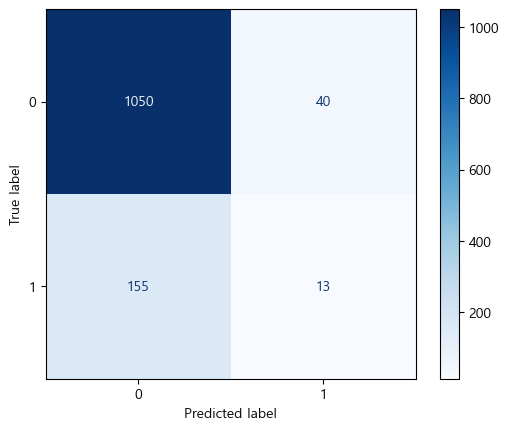

In [566]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
model = lgb.LGBMClassifier(
    n_estimators=1000,
    num_leaves=400,
    max_depth=100,
    learning_rate=0.003,
    min_child_samples=3,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
    )

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

.